In [ ]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from matplotlib import cm
from keras.datasets.cifar10 import load_data

import random
import numpy as np

2024-04-10 17:52:30.807648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 17:52:30.807784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 17:52:30.933274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def DataLoad(subset=None):
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  
  if subset is not None:
    train_length = int(len(x_train) * subset)
    x_train = x_train[:train_length]
    y_train = y_train[:train_length]
    
    test_length = int(len(x_test) * subset)
    x_test = x_test[:test_length]
    y_test = y_test[:test_length]
  
  val_split = 0.2
  val_length = int(len(x_train) * val_split)
  x_val = x_train[:val_length]
  y_val = y_train[:val_length]
  
  x_train = x_train[val_length:]
  y_train = y_train[val_length:]
  
  return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = DataLoad()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [ ]:
# Labels
lables = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

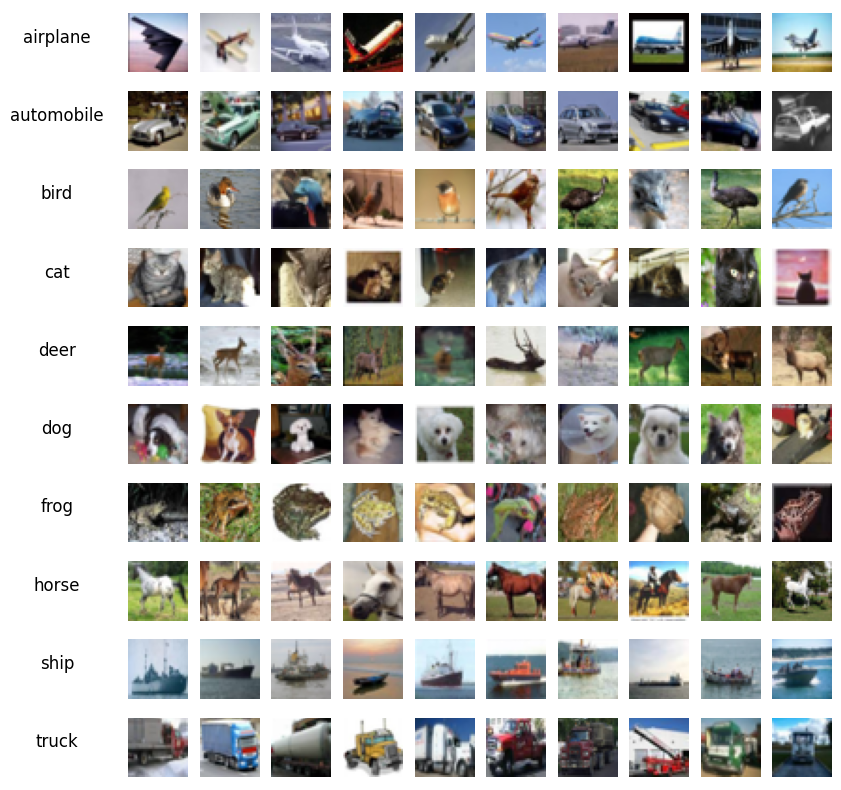

In [ ]:
# Plot the 10 images from each label
fig, axes = plt.subplots(10, 11, figsize=(10, 10))

for i in range(10):
    axes[i, 0].text(0, 0.5, lables[i], fontsize=12, ha='center')
    axes[i, 0].axis('off')
    for j in range(1, 11):  
        index = random.choice(np.where(y_train == i)[0])
        axes[i, j].imshow(x_train[index])
        axes[i, j].axis('off')

# Variational Autoencoders


## Setup


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers, losses

## Sampling Layer


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder


In [ ]:
latent_dim = 2

input_shape = (32, 32, 3)

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 2, 2, 512) │  1,180,160 │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 2048)      │          0 │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │    524,544 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_5          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,108,932 (8.04 MB)

 Trainable params: 2,108,932 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

## Decoder


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

output_shape = (32, 32, 3)

x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4096)           │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_19 (Reshape)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_50             │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_51             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_52             │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,547 (267.76 KB)

 Trainable params: 68,547 (267.76 KB)

 Non-trainable params: 0 (0.00 B)

## VAE Model


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train


In [ ]:
train_dataset = x_train
train_dataset = train_dataset.astype("float32") / 255

test_dataset = np.concatenate([x_val, x_test])
test_dataset = test_dataset.astype("float32") / 255

In [ ]:
vae = VAE(encoder, decoder)

def vae_loss(data, reconstruction):
    z_mean, z_log_var, z = encoder(data)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstruction),
            axis=(1, 2),
        )
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss
    
    return total_loss

# Compile the VAE model using the custom loss function
vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss)
# vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
history = vae.fit(train_dataset, epochs=20, batch_size=128, validation_data=(test_dataset, test_dataset))

Epoch 1/20
 16/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 0.0052 - loss: 709.1567 - reconstruction_loss: 709.1514

W0000 00:00:1712773612.682053      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - kl_loss: 1.7378 - loss: 692.9448 - reconstruction_loss: 691.2070 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 4.3631 - loss: 657.2636 - reconstruction_loss: 652.9005 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 4.1431 - loss: 656.4347 - reconstruction_loss: 652.2916 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 4.0794 - loss: 655.2664 - reconstruction_loss: 651.1869 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 4.0561 - loss: 655.5153 - reconstruction_loss: 651.4592 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconst

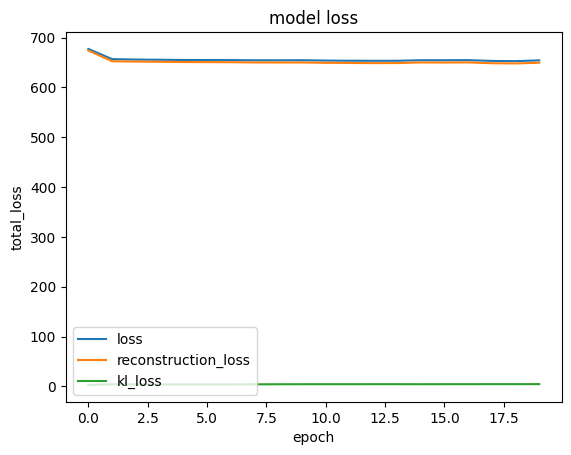

In [ ]:
# plot the loss
plt.plot(history.history["loss"])
plt.plot(history.history["reconstruction_loss"])
plt.plot(history.history["kl_loss"])
plt.title("model loss")
plt.ylabel("total_loss")
plt.xlabel("epoch")
plt.legend(["loss", "reconstruction_loss", "kl_loss"], loc="lower left")

plt.show()

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


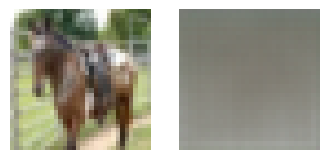

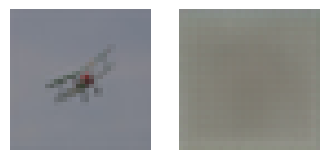

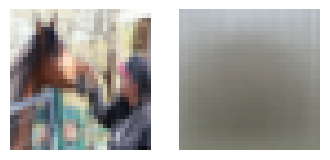

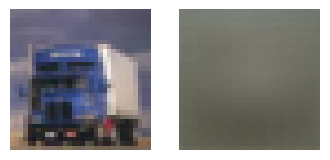

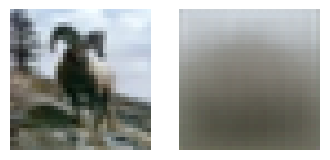

In [26]:
# Generate images
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
random_5 = np.random.randint(0, len(train_dataset), 5)
sample_5 = []
generated_5 = []
for i in random_5:
    image = train_dataset[i]
    sample_5.append(image)
    image = np.expand_dims(image, axis=0)
    z_mean, _, _ = encoder.predict(image)
    samples = decoder.predict(z_mean)
    sample = samples[0]
    generated_5.append(sample)
    
    axes[0].imshow(image[0])
    axes[0].axis('off')
    axes[1].imshow(sample)
    axes[1].axis('off')
plt.show()


In [ ]:
# Get quality of Generations

def log_likelihood_loss(y_true, y_pred): # define the negative log likelihood loss
  
  # Flatten the true and predicted pixel values
  y_true_flat = tf.reshape(y_true, shape=(-1,))
  #TypeError: Cannot convert 1.0 to EagerTensor of dtype uint8
  y_pred_flat = tf.clip_by_value(y_pred, clip_value_min=1e-7, clip_value_max=1.0)
  y_pred_flat = tf.reshape(y_pred_flat, shape=(-1,))

  # Compute the negative log likelihood
  neg_log_likelihood = -tf.reduce_mean(tf.math.log(y_pred_flat) * y_true_flat)

  return neg_log_likelihood

# frechet inception distance
from scipy import linalg
def calculateFID(y_true,y_pred, input_shape): # define the FID metric
    model = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=input_shape,weights='imagenet') # load the pre-trained model
    
    real = keras.applications.mobilenet_v2.preprocess_input(y_true) # preprocess the real and generated images
    generated = keras.applications.mobilenet_v2.preprocess_input(y_pred)
    
    real = model.predict(real)  # get the features from the pre-trained model
    generated = model.predict(generated)
    
    mu,sigma = np.mean(real, axis=0), np.cov(real, rowvar=False) # calculate the mean and covariance of the real and generated images
    mu2, sigma2 = np.mean(generated, axis=0), np.cov(generated, rowvar=False)
    
    mu_difference = mu - mu2
    sigma_epsilon = linalg.sqrtm(sigma.dot(sigma2)).real
    
    fid = np.real(mu_difference.dot(mu_difference) + np.trace(sigma + sigma2 - 2 * sigma_epsilon)) # calculate the FID
    
    return fid

In [ ]:
_sample_5 = np.array(sample_5)
_generated_5 = np.array(generated_5)

_sample_5.shape, _generated_5.shape

((5, 32, 32, 3), (5, 32, 32, 3))

In [ ]:
num_pairs = min(len(_sample_5), len(_generated_5))

# convert real samples to float32
_real_samples = _sample_5.astype(np.float32)
# convert fake samples to float32
__generated_5 = _generated_5.astype(np.float32)


# calculate the log likelihood loss
loglikelihood_1 = log_likelihood_loss(_real_samples, __generated_5)

# calculate the FID
fid_1 = calculateFID(_real_samples, __generated_5, (32, 32, 3))

print("--------------------------------")
print(f"Log Likelihood Loss:")
print(f"VAE: {loglikelihood_1}")
print("--------------------------------")
print(f"FID :")
print(f"VAE: {fid_1}")
print("--------------------------------")

/tmp/ipykernel_34/3701101615.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=input_shape,weights='imagenet') # load the pre-trained model


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
--------------------------------
Log Likelihood Loss:
VAE: 0.3002684414386749
--------------------------------
FID :
VAE: 0.11053741618025188
--------------------------------


## Intruducing beta in loss

In [ ]:
beta = 50
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss = beta * kl_loss
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
vae = VAE(encoder, decoder)

def vae_loss(data, reconstruction):
    z_mean, z_log_var, z = encoder(data)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstruction),
            axis=(1, 2),
        )
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    kl_loss = beta * kl_loss

    total_loss = reconstruction_loss + kl_loss
    
    return total_loss

# Compile the VAE model using the custom loss function
vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss)

history = vae.fit(train_dataset, epochs=20, batch_size=128, validation_data=(test_dataset, test_dataset))

Epoch 1/20
 16/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 106.5027 - loss: 776.9264 - reconstruction_loss: 670.4238

W0000 00:00:1712774396.052036      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - kl_loss: 21.3541 - loss: 713.8529 - reconstruction_loss: 692.4990 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 10.3318 - loss: 703.8749 - reconstruction_loss: 693.5432 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 10.7977 - loss: 703.4453 - reconstruction_loss: 692.6476 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 10.6099 - loss: 703.3671 - reconstruction_loss: 692.7574 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - kl_loss: 11.1136 - loss: 703.3159 - reconstruction_loss: 692.2021 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_re

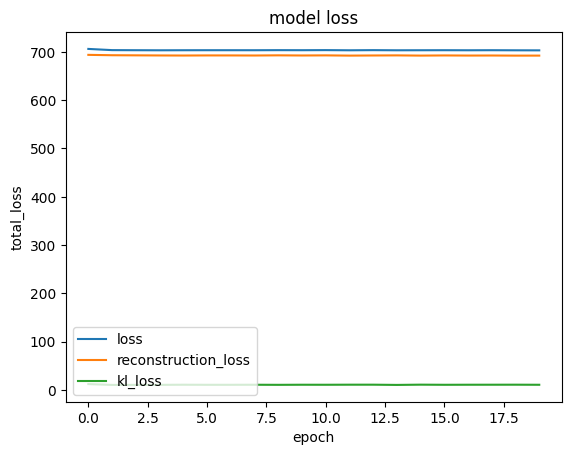

In [ ]:
# plot the loss
plt.plot(history.history["loss"])
plt.plot(history.history["reconstruction_loss"])
plt.plot(history.history["kl_loss"])
plt.title("model loss")
plt.ylabel("total_loss")
plt.xlabel("epoch")
plt.legend(["loss", "reconstruction_loss", "kl_loss"], loc="lower left")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


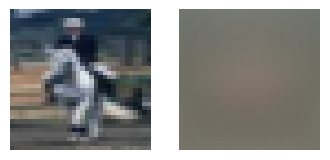

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


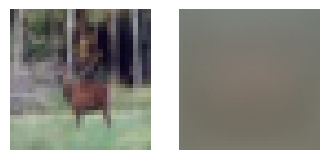

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


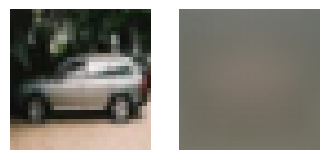

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


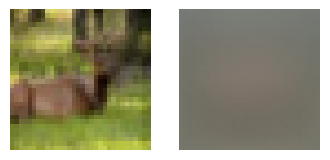

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


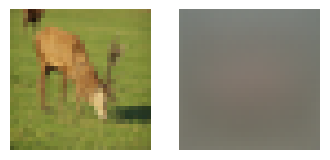

In [ ]:
# Generate images
random_5 = np.random.randint(0, len(train_dataset), 5)
sample_5_beta = []
generated_5_beta = []
for i in random_5:
    image = train_dataset[i]
    sample_5_beta.append(image)
    image = np.expand_dims(image, axis=0)
    z_mean, _, _ = encoder.predict(image)
    samples = decoder.predict(z_mean)
    sample = samples[0]
    generated_5_beta.append(sample)
    
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(image[0])
    axes[0].axis('off')
    axes[1].imshow(sample)
    axes[1].axis('off')
    plt.show()


In [ ]:
_sample_5 = np.array(sample_5_beta)
_generated_5 = np.array(generated_5_beta)

_sample_5.shape, _generated_5.shape

((5, 32, 32, 3), (5, 32, 32, 3))

In [ ]:
num_pairs = min(len(_sample_5), len(_generated_5))

# convert real samples to float32
_real_samples = _sample_5.astype(np.float32)
# convert fake samples to float32
__generated_5 = _generated_5.astype(np.float32)


# calculate the log likelihood loss
loglikelihood_2 = log_likelihood_loss(_real_samples, __generated_5)

# calculate the FID
fid_2 = calculateFID(_real_samples, __generated_5, (32, 32, 3))

print("--------------------------------")
print(f"Log Likelihood Loss:")
print(f"VAE: {loglikelihood_2}")
print("--------------------------------")
print(f"FID :")
print(f"VAE: {fid_2}")
print("--------------------------------")

/tmp/ipykernel_34/3701101615.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=input_shape,weights='imagenet') # load the pre-trained model


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
--------------------------------
Log Likelihood Loss:
VAE: 0.3118418753147125
--------------------------------
FID :
VAE: 0.0801523773634727
--------------------------------
